In [23]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)


# Optimization for Linear Regression


Today we're going to look at how to find the best linear model.

We've learned a few different ways to say this in the last lecture, but the most "machine learning-y" way is that:

1. We fixed our **model class** to be linear models, i.e. we have a functional model where we are trying to predict y from (in the simplest case) a feature x
$$ y = f(x)$$ 
and we assume that $$ f(x) = w_0 + w_1x$$

2. We fix our **loss** function to be the squared error loss function. We've written this as $\mathcal{L}$ previously, butyou will also sometimes (often) see the loss function denoted as $J$. In other words, 
$$
J(w_0,w_1) = \mathcal{L(f_{w_0, w_1})} = \frac{1}{2}\sum_{i=1}^N(y_i - (w_0 + w_1x_i))^2
$$

(Note: the $\frac{1}{2}$ is added for mathematical convenience. **Exercise:** If we're trying to find the best values of $w_0$ and $w_1$, why doesn't it matter if we have that value there or not?

Then, we need to figure out how to *find the best hypothesis/model in our hypothesis/model class!* We're going to look at three ways to do that today:

1. Closed form
2. Gradient Descent
3. Stochastic Gradient Descent

# Setup

## Data

Throughout, we'll use a few different datasets (and don't worry, we'll get back to the real-world one!), but the primary one is displayed below:

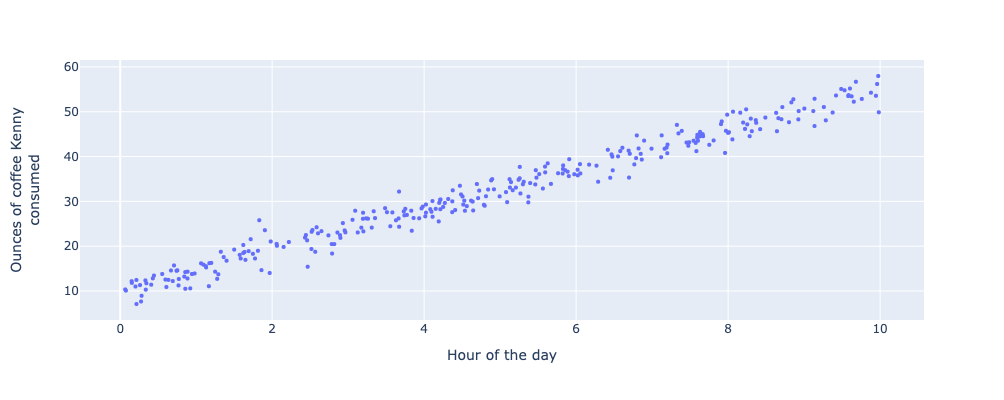

In [17]:
np.random.seed(seed=25)

DATA_SIZE = 300
w_0 = 10
w_1 = 4.5

data = pd.DataFrame(uniform(0,10).rvs(DATA_SIZE), columns=['x'])
data['y'] = w_0 + w_1*data['x'] + norm(0,2).rvs(DATA_SIZE)

fig = px.scatter(data, x="x",y='y', 
           labels = {"x" : "Hour of the day", 
                     "y" : "Ounces of coffee Kenny<br>consumed"},
          height=400, width=600)
fig.update_traces(marker={'size': 4})
fig.show()

## Big picture: What are we trying to do?

Before we jump into how to optimize, it's worth thinking through what we're actually trying to do. We are *trying to find the values of $w_0$ and $w_1$ that 

In [18]:
def objfunction(w,w0,X,y):
    J = 0.5*np.sum((y - (w*X + w0))**2)
    return J

In [20]:
X = data['x']
y = data['y']
# compute the objective function for a range of values for w and w0
w1s = np.linspace(-4, 4, 50)
w0s = np.linspace(-50, 50, 50)
W, W0 = np.meshgrid(w1s, w0s)
Js = []
for w1,w0 in zip(W.flatten(),W0.flatten()):
    Js.append(objfunction(w1,w0,X,y))

Js = np.array(Js)
Js = np.reshape(Js,(len(w1s),len(w0s)))    

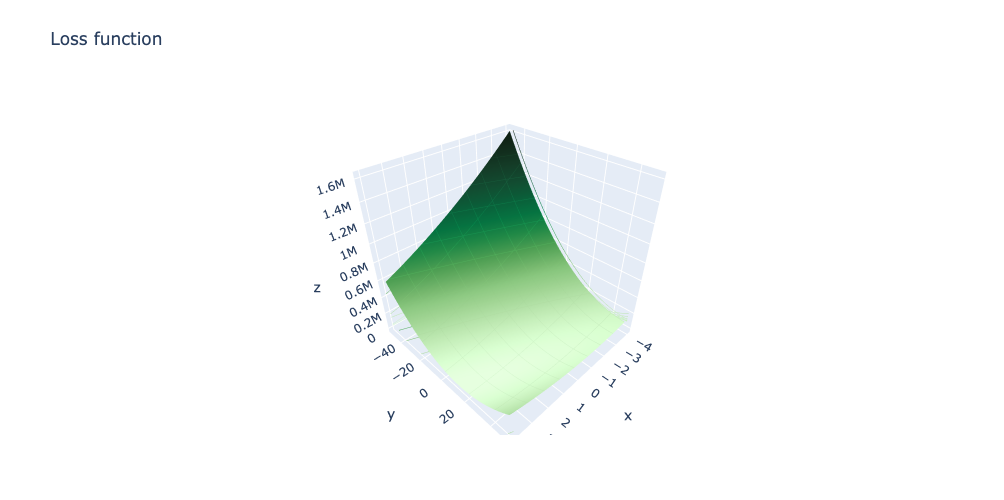

In [21]:
cs = 'algae'
fig = go.Figure(data=[go.Surface(z=Js, x=W, y=W0,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_traces(contours_x=dict(show=True, usecolormap=True,project_x=True))
fig.update_traces(contours_y=dict(show=True, usecolormap=True,project_y=True))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,project_z=True))
fig.update_layout(title='Loss function', autosize=False,
                  width=500, height=500,
                  #scene = dict(zaxis=dict(range=[-3,3])),
                  margin=dict(l=65, r=50, b=65, t=90))


**One important note:** this loss function is *convex*, and so it has a *single, unique, global minimum*. Here's a non-convex function:

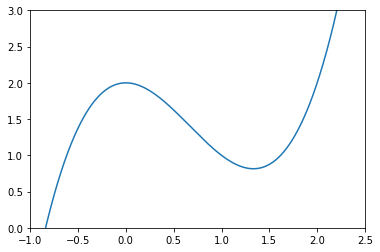

In [24]:
def f(x):
    return x**3-2*x**2+2

x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

Some of what we're doing here relies on the convexity of the loss function for a linear model with MSE as a loss function - that is, on the fact that the **Ordinary Least Squares (OLS) estimator is convex**.


# Optimization approach 1: Closed Form


First, some notes:
- The derivative of a function represents its slope at a particular value of $x$
- Where the derivative is 0, we have identified a **local** maxima/minima (we can check the second derivative to determine if it is a maximum or minimum point)

**Exercise (don't peek)**: how are the points above related to finding the best possible values of $w_0$ and $w_1$?


## How to do it - $w_0$ and $w_1$ only
 
A reminder of our loss function
$$J(w_0,w_1) = \frac{1}{2}\sum_{i=1}^N(y_i - (w_0 + w_1x_i))^2$$

Now, we want to minimize the loss. This is an optimization problem:

$$
\mathop{\mathrm{argmin}}_{w_0, w_1}  \frac{1}{2}\sum_{i=1}^N(y_i - (w_0 + w_1x_i))^2
$$

We can try to solve this optimization problem by taking the *partial derivative* of our loss function with respect to both $w_1$ and $w_0$ and setting each of those equal to zero. We can then solve for the respective values; because our function is convex, these will be the values that reach the global minimum of the loss function. 

I'm not going to derive this in class, and you are *not responsible for knowing how to derive this for the case of only $w_0$ and $w_1$*, since this is a special case. But for those interested, there's a nice, detailed derivation [here](https://are.berkeley.edu/courses/EEP118/current/derive_ols.pdf).

The end equations, though (where $\bar{x}$ is the sample mean of $x$ and $\bar{y}$ is the sample mean of $y$:

$$w_1 = \frac{
        \sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})
        }{
            \sum_{i=1}^N (x_i - \bar{x})^2
            }
$$

Note that can be derived differently and leads to $\frac{\mathrm{Cov}(x,y)}{\mathrm{Var}(x)}$ ... which is the same thing! (See [Shalizi, Section 1.4](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf) if you're curious, you are not responsible for knowing this though).

$$ 
w_0 = \bar{y} - w_1*\bar{x}
$$
      


In [31]:


## Closed-form optimization (w_0 and w_1)

def learn_OLS_regression_simple(x,y):
    # Inputs:                                                         
    # X = N x 1 
    # y = N x 1                                                               
    # Output: 
    # w0, w1

    
    ## LET'S IMPLEMENT!!

    return w0, w1

x = data['x']
y = data['y']
print(learn_OLS_regression_simple(x,y))

(10.152230139006953, 4.487660185206517)


## Moving to the more general case


In class, we will discuss how if we 1) move $w_0$ into the feature set with a little trick, and then 2) are instead looking at many features instead of one feature, it becomes more clear (although equivalent) to write the loss function in vector/matrix notation, as:
$$
J({\bf w}) = \frac{1}{2}({\bf y} - {\bf Xw})^\top({\bf y} - {\bf Xw})
$$

If we take the derivative of this loss function and set that equal to zero, we can derive that the loss function is maximized when:
$$
{\bf w} = ({\bf XX^\top})^{-1}{\bf Xy^\top}
$$

I will show this derivation in class, largely following [Dr. Chandola's derivation in his scans](https://mlcourse-ub.readthedocs.io/en/latest/_downloads/dc4c4a204def42ede6a0c24e9e52a169/linear-regression-scans.pdf).

However, let's try to implement this in code below!

In [43]:
def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 

    # WRITE THE CODE THAT IMPLEMENTS THE EQUATION ABOVE!
    
    return w

X =  np.vstack([np.ones(len(x)),x]).T
learnOLERegression(X,y)

array([10.15223014,  4.48766019])

Closed form is great, but perhaps surprisingly (it's closed form after all!) It can actually be extremely expensive for large datasets (**exercise: why?**).

Also, closed form expressions only exist for certain optimization problems we are interested in for this course. As such, it is useful to now introduce two more general approaches to optimizating model parameters that we will see over and over again in this course.

## Method 2: Gradient Descent


### An intro to gradient descent in general

These notes are drawn from [Dr. Chandola's notes on linear regression](https://github.com/ubdsgroup/mlcourse-ub-notebooks/blob/master/notebooks/LinearSystems.ipynb).

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess ${\bf w}^{(0)}$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f({\bf w}^{(k)})$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ${\bf w}^{(k+1)} = {\bf w}^{(k)} + \eta s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [44]:
def f(x):
    return x**3-2*x**2+2

def f_prime(x):
    return 3*x**2-4*x

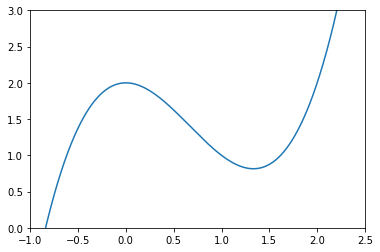

In [45]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

In [69]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size  ### TEST: .3, 3
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))


Text(0.5, 1.0, 'Gradient descent')

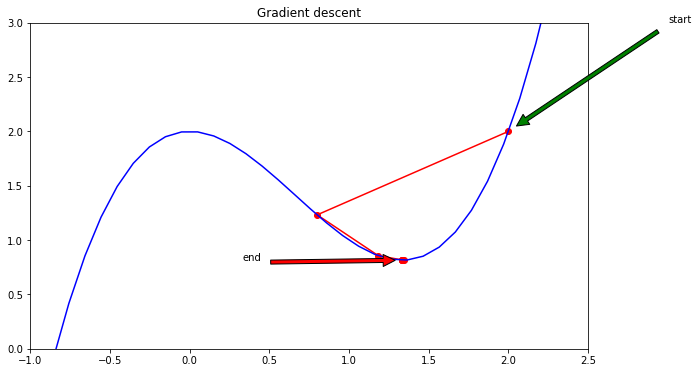

In [70]:
plt.figure(figsize=[10,6])
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.annotate(xy=(x_list[0],f(x_list[0])),
             xytext=(x_list[0]+1,f(x_list[0])+1),
             text='start',
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(xy=(x_list[-1],f(x_list[-1])),
             xytext=(x_list[-1]-1,f(x_list[-1])),
             text='end',
             arrowprops=dict(facecolor='red', shrink=0.05),)
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")

Consider another function:
$$
f(x,y) = 5\cos(x - 2) + 5\sin(x - 2y)
$$
The derivative of this function will be:
$$
\nabla f = \left[\begin{array}{c}-5\sin(x-2) + 5\cos(x - 2y) \\ -10\cos(x-2y) \end{array}\right]
$$

In [50]:
def f2(x,y):
    return 5*np.cos(x -2) + 5*np.sin(x - 2*y)

def f2_prime(x,y):
    return np.array([-5*np.sin(x -2) + 5*np.cos(x - 2*y),-10*np.cos(x-2*y)])

In [58]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

X, Y = np.meshgrid(x, y)
Z = f2(X, Y)

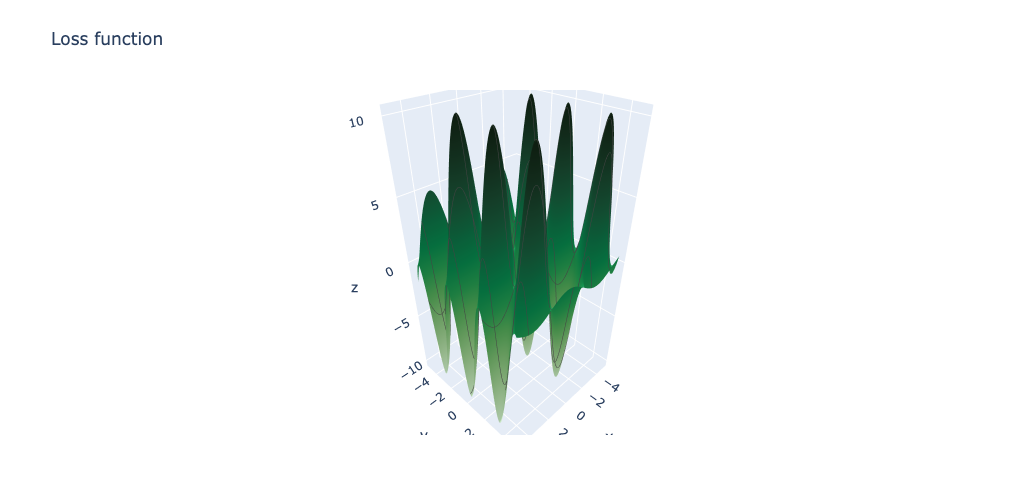

In [59]:
cs = 'algae'
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_layout(title='Loss function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))



In [66]:
x_old = np.array([2,-2]) #np.array([0,0])
x_new = np.array([1.5,-1.5]) #np.array([1,1])
n_k = 0.01 # step size
precision = 0.0001

x_list, y_list = [x_new], [f2(x_new[0],x_new[1])]
while np.sum(np.abs(x_new - x_old)) > precision:
    x_old = x_new
    s_k = -f2_prime(x_old[0],x_old[1])
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f2(x_new[0],x_new[1]))
x_list = np.array(x_list)
y_list = np.array(y_list)

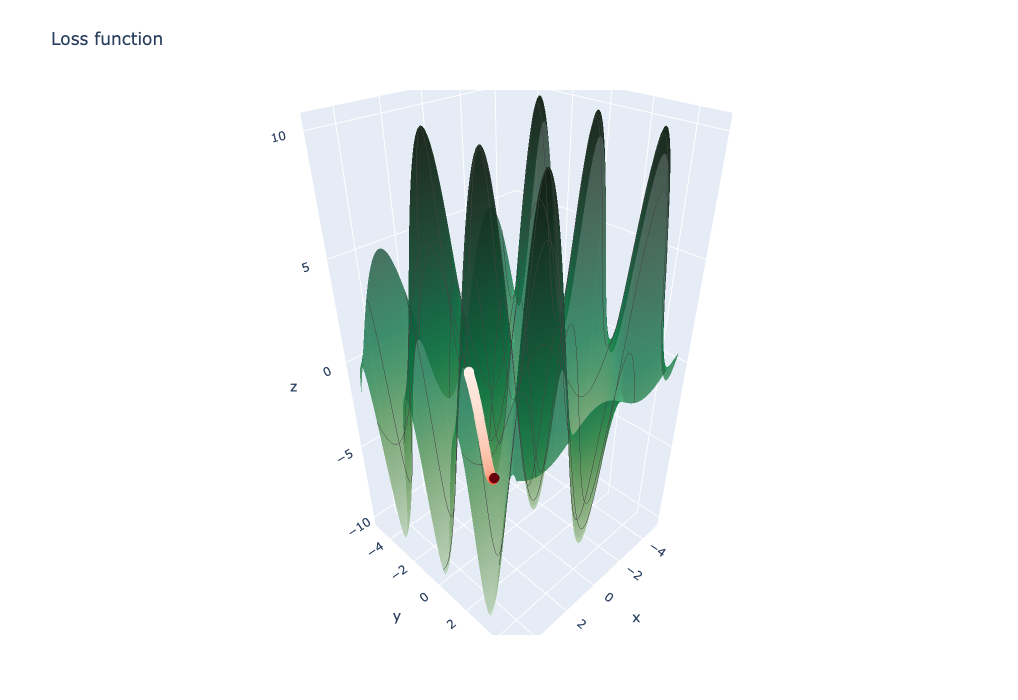

In [67]:
cs = 'algae'
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 opacity=0.75,
                                 colorscale=cs
                                ),
                      go.Scatter3d(x=x_list[:,0], y=x_list[:,1], z=y_list,
                                 mode='markers',
                                 marker=dict(size=6,
                                             color=np.arange(len(y_list)),
                                             colorscale='reds',
                                             opacity=0.8)
                                )
                     ])
fig.update_layout(title='Loss function', autosize=False,
                  width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))




### Linear Regression with Gradient Descent

We are optimizing the linear regression loss function.

- **Exercise:** what is f(x) in this case that we are minimizing with gradient descent?
- **Exercise:** what is f'(x) in this case that we are using to take steps in the direction of the gradient?

In [104]:
def regressionObjVal(w, X, y):

    # compute squared error (scalar) with respect
    # to w (vector) for the given data X and y      
    #
    # Inputs:
    # w = d x 1
    # X = N x d
    # y = N x 1
    # Output:
    # error = scalar value

    # IMPLEMENT THIS METHOD

    return error

In [105]:
def regressionGradient(w, X, y):

    # compute gradient of squared error (scalar) with respect
    # to w (vector) for the given data X and y   
    
    # Inputs:
    # w = d x 1
    # X = N x d
    # y = N x 1
    # Output:
    # gradient = d length vector (not a d x 1 matrix)

    # IMPLEMENT!

    return J

In [106]:
from scipy.optimize import minimize
x = data['x']
y = data['y'].values.reshape(len(data),1)
X =  np.vstack([np.ones(len(x)),x]).T
args = (X,y)
opts = {'maxiter' : 100}    # Preferred value.    
w_init = np.ones((X.shape[1],1))
soln = minimize(regressionObjVal, w_init, jac=regressionGradient, args=args,method='CG', options=opts)
soln.x

NameError: name 'error' is not defined

# Method 3: Stochastic Gradient Descent

The one issue with gradient descent ... it still uses all the data! That is, we have to compute the loss and the gradient on the loss on all the data. This can be particularly problematic when the data is large, especially if it resides on different machines (e.g. in a Hadoop cluster). 

It would be nice to instead use only a subset of the data, and still be sure that we get the optimal answer.  **Turns out, we can!**

The **stochastic gradient descent** algorithm allows us to use **single data points** from our dataset to compute gradients and update our weights in the gradient descent algorithm.  *It is, in my humble opinion, actually kind of crazy that this works!* I will not delve into the mathematics of *why* this works, although you can [see here](https://www.cs.cornell.edu/courses/cs4787/2021sp/lectures/Lecture5.pdf) for a nice explanation. The general idea is that these points, if sampled uniformly, create a valid measure of the *expectation* of the gradient, and you can prove (with some effort) that you can use this expectation of the gradient to converge (with a few caveats).

*You are not responsible for understanding that math for this course, but you will, in a future time period, be responsible for understanding how to implement stochastic gradient descent*. More on that last part in future programming assignments :).



# Two Miscellaneous Things

### Numerical instability

In [174]:
X = np.array([[1,3,4,7],[1,4,2,6],[1,8,-3,5],[1,4,7,11],[1,3,2,5]])
print(X)
y = np.array([5,2,3,9,7])
print(y)

[[ 1  3  4  7]
 [ 1  4  2  6]
 [ 1  8 -3  5]
 [ 1  4  7 11]
 [ 1  3  2  5]]
[5 2 3 9 7]


$X^\top X$

In [175]:
np.dot(X.transpose(),X)

array([[  5,  22,  12,  34],
       [ 22, 114,  30, 144],
       [ 12,  30,  82, 112],
       [ 34, 144, 112, 256]])

In [176]:
np.linalg.inv(np.dot(X.transpose(),X))

LinAlgError: Singular matrix

The above experiment shows that if your data has redundancy (repeating values), the inverse of the $X^\top X$ matrix will be unstable. However, if you use `sklearn` LinearRegression implementation, you will still see a valid solution (See below).

> Why?

In [177]:
from sklearn.linear_model import LinearRegression
lmodel = LinearRegression(fit_intercept=False)
lmodel.fit(X,y)
print(lmodel.coef_)

[ 2.19433198 -0.0242915   0.3562753   0.33198381]


### Looking ahead: The problem with outliers


In [107]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

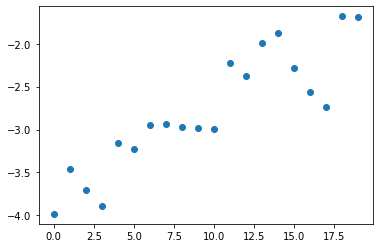

In [110]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,np.sqrt(sigma2),x.shape[0])
plt.scatter(x,y)

In [111]:
def calculateSquaredLoss(X,y,w):
    X1 = np.hstack([np.ones([X.shape[0],1]),X])
    ypred = np.dot(X1,w)
    return 0.5*np.sum(np.power(ypred - y,2))

In [113]:
from sklearn.linear_model import LinearRegression
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

-3.775 +  0.104 * X1


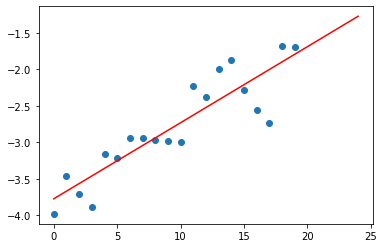

In [114]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest,ytest, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

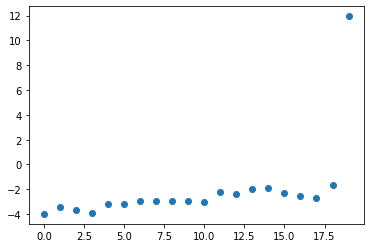

In [115]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [116]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))


-4.944 +  0.299 * X1


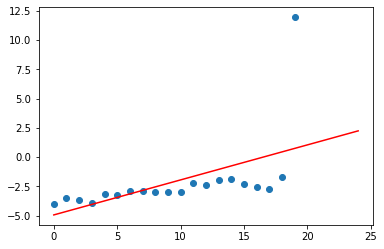

In [117]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

**Exercise (don't peak!):** What would you do?

### A solution: use a different model class!

Here, we could use a model called robust regression. The `statsmodels` package has a robust linear regression model function (`rlm`). We won't delve into the details, this is just note foreshadowing that we can address problems by changing the model class

In [118]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([np.ones(x.shape[0]),x.flatten()]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print(pretty_print_linear(w[1:],w[0]))


-3.855 +  0.119 * X1


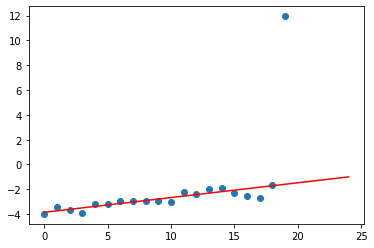

In [119]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = w[0] + w[1]*xtest
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

# Wrapping up

We now know what linear regression is (as a model/hypothesis class), and how to optimize it in three different ways. 

There are two things that remain:
1. How do we evaluate our model?
2. How do we understand the coefficients in the model?

To address these, we'll return to our real-world example.